# Automated Health Information Extraction and Co-occurrence Analysis with John Snow Labs Models

🔎 In this analytical endeavor, we utilize Natural Language Processing (NLP) to unlock vital insights from health-related discussions across various digital platforms. The primary goal is to pinpoint patterns that could suggest the presence of co-occurring health risks, contributing substantially to preventive health strategies.

🔎 By deploying John Snow Labs' NLP models, we extract essential health information from these discussions. This not only includes diseases and conditions but also risk factors, lifestyle habits such as alcohol consumption, and even complex aspects like family health history and the status of alcohol, tobacco, and substance behaviors.

🔎 Our exploration progresses into a risk analysis phase, wherein we concentrate on identifying patterns of health conditions that frequently appear together. For instance, a common co-occurrence of "smoking" and "lung cancer" in discussions could underscore critical health risks often linked together.

🔎 The insights generated from this work aim to bolster our understanding of digital health discussions and help predict potential health risks.

In [1]:
import os, json
import pandas as pd
import numpy as np
import warnings
import logging
import re

from ast import literal_eval
from ast import literal_eval
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
logging.getLogger().setLevel(logging.ERROR)

pd.set_option('display.max_columns', None)
# pd.set_option("display.max_colwidth",50)

## Read and Merge Results

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

result_pd = pd.read_csv("result_pd.csv")
ASSERTION_BEHAVIOUR = pd.read_csv("ASSERTION_BEHAVIOUR.csv")
ASSERTION_DISEASE = pd.read_csv("ASSERTION_DISEASE.csv")
icd10cm_code = pd.read_csv("icd10cm_code.csv")


result_pd_last = pd.merge(result_pd, ASSERTION_BEHAVIOUR, on = ['text_id', 'text',"gender_class","ner_chunk",'entity'],how="left")
result_pd_last = pd.merge(result_pd_last, ASSERTION_DISEASE, on = ['text_id', 'text',"gender_class","ner_chunk",'entity'],how="left")
result_pd_last = pd.merge(result_pd_last, icd10cm_code, on = ['text_id', 'text',"gender_class","ner_chunk",'entity'],how="left")

result_pd_last.tail(3)

,text_id,text,gender_class,ner_chunk,entity,ASSERTION_BEHAVIOUR,ASSERTION_DISEASE,icd10cm_code
21566,3358,"When I have a migraine, taking a nap usually s...",Female,migraine,DISEASE,NaN,NaN,NaN
21567,3359,Soldiers must have been getting PTSD even back...,Female,Soldiers,PROFESSION,NaN,NaN,NaN
21568,3359,Soldiers must have been getting PTSD even back...,Female,PTSD,PSYCHOLOGICAL_CONDITION,NaN,NaN,NaN


## Getting Age group information

In [3]:
import statistics
from statistics import mode
import re

for i,row in  result_pd_last.iterrows():
    if row["entity"] == "AGE":
        agelist = re.findall("\\d{1,2}", row["ner_chunk"])
        agelabel = []
        for age in agelist:
            age = int(age)
            if ((age <=20) and (age >= 0)):
                agelabel.append("Young")
            elif ((age <=40) and (age > 20)):
                agelabel.append("Adult")
            elif age > 40:
                agelabel.append("Old")
            else:
                agelabel.append("Unknown")
        if len(agelabel)>0:
            text_id = result_pd_last.loc[i,"age_group"] =mode(agelabel) 
            result_pd_last[result_pd_last.text_id == text_id]["age_group"] = mode(agelabel) 
    else:
         result_pd_last.loc[i,"age_group"] =""

result_pd_last.fillna("",inplace=True)
result_pd_last.age_group.value_counts()

         21302
Young      142
Adult       64
Old         61
Name: age_group, dtype: int64

## Getting NER based Gender information

In [4]:
female_list = ["her","she", "she's", "she’s", "shes", "woman", "female", "mother","girl","lady","herself","women","Wife's","girlfriend"]
male_list = ["his","he", "he's","he’s", "man", "men","male", "him", "himself", "father", "boy","sir","daddy","He‘s"]
for i,row in  result_pd_last.iterrows():
    if row["entity"] == "GENDER":
        gender = row["ner_chunk"].lower()
        if gender in female_list:
            result_pd_last.loc[i,"Entity_based_Gender"] = "Female"
        elif gender in male_list:
            result_pd_last.loc[i,"Entity_based_Gender"] = "Male"
        else: 
            result_pd_last.loc[i,"Entity_based_Gender"] = ""

result_pd_last.fillna("",inplace=True)
result_pd_last.Entity_based_Gender.value_counts()

          17678
Male       2139
Female     1752
Name: Entity_based_Gender, dtype: int64

## Getting ICD10 Grouped Codes

In [5]:
icd10_major_codes = pd.read_csv("icd10_major_codes.csv",header=0)

for i, row in icd10_major_codes.iterrows():
    firstcode, last_code = row["Code"].split("-")
    icd10_major_codes.loc[i,"Char"] = firstcode[0]
    icd10_major_codes.loc[i,"firstcode"] = firstcode[1:3]
    icd10_major_codes.loc[i,"last_code"] = last_code[1:3]
    
icd10_major_codes

,Code,Description,Group,Char,firstcode,last_code
0,A00-A09,Intestinal infectious diseases,Infectious Diseases,A,00,09
1,A15-A19,Tuberculosis,Infectious Diseases,A,15,19
2,A20-A28,Certain zoonotic bacterial diseases,Infectious Diseases,A,20,28
3,A30-A49,Other bacterial diseases,Infectious Diseases,A,30,49
4,A50-A64,Infections with a predominantly sexual mode of...,Infectious Diseases,A,50,64
...,...,...,...,...,...,...
217,Z80-Z99,Persons with potential health hazards related ...,other_codes,Z,80,99
218,U00-U06,Provisional assignment of new diseases of unce...,other_codes,U,00,06
219,U07-U12,Covid-19,Covid-19,U,07,12
220,U13-U49,Provisional assignment of new diseases of unce...,other_codes,U,13,49


In [6]:
for i,row in  result_pd_last.iterrows():
    if row["icd10cm_code"] != "":
        icd_char = row["icd10cm_code"][0]
        icd_numb = row["icd10cm_code"][1:3]

        group_desc = icd10_major_codes[(icd10_major_codes.Char == icd_char) & 
                          ((icd10_major_codes.firstcode <=icd_numb )
                           &(icd10_major_codes.last_code >=icd_numb)) ][["Group"]].reset_index(drop=True)
        if len(group_desc)>0:
            result_pd_last.loc[i,"ICD10_Grouped"] = group_desc.loc[0,"Group"]
    else:
        result_pd_last.loc[i,"ICD10_Grouped"] =""
        
result_pd_last.fillna("",inplace=True)
result_pd_last.ICD10_Grouped.value_counts()

                                               18941
Neurological disorders                           413
Cancer                                           407
External causes of health problems               375
Respiratory Diseases                             334
other_codes                                      267
Vascular Disorders                               159
General Symptoms of disorders                    158
Endocrine (hormonal) disorders                   141
Mental/Psychological disorders                   136
Pregnancy (obstetric) and newborn disorders       81
Infectious Diseases                               72
Covid-19                                          22
Musculoskeletal disorders                         12
Gastrointestinal Diseases                         11
Genitourinary System disorders                    11
Eye and ear disorder                              11
Blood disorders                                    9
Skin (dermatological) disorders               

In [7]:
result_pd_last.fillna("",inplace=True)
result_pd_last.to_csv("result_pd_last.csv",index=False)
result_pd_last.tail(3)

,text_id,text,gender_class,ner_chunk,entity,ASSERTION_BEHAVIOUR,ASSERTION_DISEASE,icd10cm_code,age_group,Entity_based_Gender,ICD10_Grouped
21566,3358,"When I have a migraine, taking a nap usually s...",Female,migraine,DISEASE,,,,,,
21567,3359,Soldiers must have been getting PTSD even back...,Female,Soldiers,PROFESSION,,,,,,
21568,3359,Soldiers must have been getting PTSD even back...,Female,PTSD,PSYCHOLOGICAL_CONDITION,,,,,,


## Pivot table

In [8]:
pd_last = result_pd_last.replace("",np.nan).groupby(["text_id","text","gender_class"]).agg({"ASSERTION_BEHAVIOUR":pd.Series.mode,
                                                                                  "ASSERTION_DISEASE":pd.Series.mode,
                                                                                  "age_group":pd.Series.mode,
                                                                                  "ICD10_Grouped":pd.Series.mode,
                                                                                  "Entity_based_Gender":pd.Series.mode,
                                                                                  "icd10cm_code":pd.Series.mode # lambda x : [ i for i in x if (i!= np.nan) ]  
                                                                                 }).reset_index()

for i, row in pd_last.iterrows():
    for col in ["ASSERTION_BEHAVIOUR","ASSERTION_DISEASE","age_group","ICD10_Grouped","Entity_based_Gender","icd10cm_code"]:
        if len(row[col])>0:
            if type(row[col])==list:
                pd_last.loc[i, col] = row[col][-1]
            elif type(row[col])== np.ndarray:
                pd_last.loc[i, col] = row[col][-1]
                pass
        else:
            pd_last.loc[i, col] = ""
            


# Group by 'text' and 'entity' columns, then aggregate 'ner_chunk' into lists
result_df_slim = result_pd.groupby(['text_id', 'text',"gender_class",'entity',]).agg({'ner_chunk':list}).reset_index()

# Pivot the DataFrame
result_pivot = result_df_slim.pivot(['text_id', 'text',"gender_class",  ], columns='entity', values='ner_chunk')

# Fill NaN values with placeholder
result_pivot.fillna(value="", inplace=True) # value="placeholder"

# Reset index to make 'text' a regular column
result_pivot.reset_index(inplace=True)
result_pivot = result_pivot.replace("Unknown","")

result_pivot = pd.merge(result_pivot, pd_last, on = ['text_id', 'text',"gender_class"],how="left")

#for col in result_pivot.columns:
#    result_pivot[col] = result_pivot[col].apply(lambda x: x[0] if list == type(x) else x)
    
result_pivot.fillna(value="", inplace=True)

result_pivot.to_csv("result_pivot.csv",index=False)

result_pivot.tail()

,text_id,text,gender_class,ACCESS_TO_CARE,AGE,ALCOHOL,ALLERGEN,CHILDHOOD_EVENT,COMMUNITY_SAFETY,DIET,DISABILITY,DISEASE,DRUG,EATING_DISORDER,EDUCATION,EXERCISE,FAMILY_MEMBER,FINANCIAL_STATUS,FOOD_INSECURITY,GENDER,GEOGRAPHIC_ENTITY,HEALTHSTATUS,HOUSING,INCOME,INJURYORPOISONING,INSURANCE_STATUS,MEDICALDEVICE,OBESITY,PROFESSION,PSYCHOLOGICAL_CONDITION,RACE_ETHNICITY,RELATIONSHIPSTATUS,SEXUAL_ACTIVITY,SEXUAL_ORIENTATION,SMOKER,SOCIAL_EXCLUSION,SPIRITUAL_BELIEFS,SUBSTANCE,SYMPTOM,TOTAL_CHOLESTEROL,TREATMENT,VACCINE,VIOLENCE_OR_ABUSE,ASSERTION_BEHAVIOUR,ASSERTION_DISEASE,age_group,ICD10_Grouped,Entity_based_Gender,icd10cm_code
3350,3355,My workaholic friend in Taiwan just had a hear...,Male,,,,,,,,,[heart attack],,,,,,,,[he],,,,,,,,,,,,,,,,,,,,,,,,,Past,,Vascular Disorders,Male,I21.9
3351,3356,Two guys die and arrive at the pearly gates an...,Male,,,,,,,,,[heart attack],,,,,[wife],,,"[he, his, he]",[St],,,,,,,,,,,,,,,,,,,,,,,,Family,,Vascular Disorders,Male,I21.9
3352,3357,"For not having any nerves in my brain, a migra...",Female,,,,,,,,,[migraine],,,,,,,,,,,,,,,,,,[helpless infant crying],,,,,,,,,,,,,,,,,,,
3353,3358,"When I have a migraine, taking a nap usually s...",Female,,,,,,,,,[migraine],,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3354,3359,Soldiers must have been getting PTSD even back...,Female,,,,,,,,,,,,,,,,,,,,,,,,,,[Soldiers],[PTSD],,,,,,,,,,,,,,,,,,,


## Coorelation Table

In [9]:
corr = pd.DataFrame(columns=result_pivot.columns[2:], index=result_pivot.columns[2:])
for col_left in result_pivot.columns[2:]:
    for col_right in result_pivot.columns[2:]:

        corr.loc[col_left ,col_right ] = len(result_pivot[(result_pivot[col_left]!="") & (result_pivot[col_right]!="").any()])
        
corr.columns.name=None
corr.index.name=None

corr.to_csv("corr_table.csv")

corr

,gender_class,ACCESS_TO_CARE,AGE,ALCOHOL,ALLERGEN,CHILDHOOD_EVENT,COMMUNITY_SAFETY,DIET,DISABILITY,DISEASE,DRUG,EATING_DISORDER,EDUCATION,EXERCISE,FAMILY_MEMBER,FINANCIAL_STATUS,FOOD_INSECURITY,GENDER,GEOGRAPHIC_ENTITY,HEALTHSTATUS,HOUSING,INCOME,INJURYORPOISONING,INSURANCE_STATUS,MEDICALDEVICE,OBESITY,PROFESSION,PSYCHOLOGICAL_CONDITION,RACE_ETHNICITY,RELATIONSHIPSTATUS,SEXUAL_ACTIVITY,SEXUAL_ORIENTATION,SMOKER,SOCIAL_EXCLUSION,SPIRITUAL_BELIEFS,SUBSTANCE,SYMPTOM,TOTAL_CHOLESTEROL,TREATMENT,VACCINE,VIOLENCE_OR_ABUSE,ASSERTION_BEHAVIOUR,ASSERTION_DISEASE,age_group,ICD10_Grouped,Entity_based_Gender,icd10cm_code
gender_class,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268,3268
ACCESS_TO_CARE,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85
AGE,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230
ALCOHOL,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150
ALLERGEN,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170
CHILDHOOD_EVENT,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
COMMUNITY_SAFETY,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35
DIET,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35
DISABILITY,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28
DISEASE,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010


## Helper Functions

### Replacement dictionary

In [10]:
# Replacement dictionary
replacement_dict = {
    'drink': 'alcohol',
    'Drinking': 'alcohol',
    'drank': 'alcohol',
    'drinks': 'alcohol',
    'drunk': 'alcohol',
    'drink coffee' : "caffeine",
    'drinking': 'alcohol',
    "drinkers" : "alcohol",
    'Alcohol': 'alcohol',
    "Alcohol's": 'alcohol',
    "alcoholic" : 'alcohol',
    "alcoholics" : 'alcohol',
    "beer" : 'alcohol',
    'Cancer': 'cancer',
    'cancer.': 'cancer',
    "Cancer's": 'cancer',
    "my depresion": "depresion",
    "kids" : "kids",
    "doctors" : "doctor",
    "Officer" : "officer",
    "class teacher": "teacher",
    "teachers": "teacher",
    "Cop" : "police officer",
    "smoke": "smoking",
    "smoked": "smoking",
    "smokes": "smoking",
    "smokers": "smoking",
    "smoker": "smoking",
    "cigarettes": "smoking",
    "cigarette a day from a cigarette a week":"smoking",
    "became at least 2-3 cigarettes a day":"smoking",
    "God":"god",
    "GOD":"god",
    "allergiesies":"allergy",
    
    }

###  network graph

In [11]:
def plot_graph(main_df: pd.DataFrame, col1: str, col2: str, replacement_dict: dict, exclude_terms: list = [], min_count: int = 3) -> None:
    """
    This function receives a dataframe and two columns to analyze. It also takes a replacement dictionary for reassigning the terms in the dataframe. 
    It prints out some information about the data and plots a network graph.
    """

    df = main_df.copy()
    
    # Total amount of data points
    total_data = df.shape[0]
    
    # Replacing empty lists with NaNs
    df[[col1, col2]] = df[[col1, col2]].applymap(lambda x: np.nan if x == "" else x)

    # Check if the item is already a list, if not, convert the string representation of the list back to an actual list
    df[col1] = df[col1].apply(lambda x: x if isinstance(x, list) else (literal_eval(x) if pd.notnull(x) else []))
    df[col2] = df[col2].apply(lambda x: x if isinstance(x, list) else (literal_eval(x) if pd.notnull(x) else []))

    # Exclude terms from the columns
    df[col1] = df[col1].apply(lambda lst: [item for item in lst if item not in exclude_terms])
    df[col2] = df[col2].apply(lambda lst: [item for item in lst if item not in exclude_terms])


    # Filtering the dataframe for rows that contain both column 1 and column 2 elements
    df_filtered = df[(df[col1].apply(len) > 0) & (df[col2].apply(len) > 0)]

    # Applying the replacement mapping
    df_filtered[col1] = df_filtered[col1].apply(lambda lst: [replacement_dict.get(item, item) for item in lst])
    df_filtered[col2] = df_filtered[col2].apply(lambda lst: [replacement_dict.get(item, item) for item in lst])

    # Getting the top 5 elements from column 1
    col1_counts = Counter([item for sublist in df_filtered[col1] for item in sublist])
    top_5_col1 = [item for item, _ in col1_counts.most_common(5)]

    # Creating a dictionary to hold co-occurrence counts
    co_occurrences = {}
    for _, row in df_filtered.iterrows(): 
        for col1_item in row[col1]:
            if col1_item in top_5_col1:
                for col2_item in row[col2]:
                    co_occurrences.setdefault(col1_item, {}).setdefault(col2_item, 0)
                    co_occurrences[col1_item][col2_item] += 1
                    
    filtered_co_occurrences = {}
    for col1_item, sub_dict in co_occurrences.items():
        for col2_item, count in sub_dict.items():
            if count >= min_count:
                filtered_co_occurrences.setdefault(col1_item, {})[col2_item] = count
                

    # Building the network graph
    G = nx.Graph()
    for col1_item, sub_dict in filtered_co_occurrences.items():
        for col2_item, count in Counter(sub_dict).most_common(5):
            G.add_edge(col1_item, col2_item, weight=count)

    # Plotting the network graph
    plt.figure(figsize=(11, 11))
    pos = nx.spring_layout(G, k=0.6)
    node_colors = ['red' if node in top_5_col1 else 'skyblue' for node in G.nodes]
    nx.draw(G, pos, with_labels=False, node_color=node_colors, edge_color='grey', node_size=2000)
    label_pos = {node: (x, y+0.03) for node, (x, y) in pos.items()}
    nx.draw_networkx_labels(G, label_pos, font_size=12)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.show()

    # Print data summary
    print(f"Total data points: {total_data}")
    print(f"Data points containing {col1} elements: {df[df[col1].apply(len) > 0].shape[0]}")
    print(f"Data points containing both {col1} and {col2} elements: {df_filtered.shape[0]}")

    # Getting the counts for each column
    col1_counts = Counter([item for sublist in df_filtered[col1] for item in sublist])
    col2_counts = Counter([item for sublist in df_filtered[col2] for item in sublist])

    # Printing the top 5 elements for each column
    print("\nTop 5 elements for " + col1 + ":")
    for item, count in col1_counts.most_common(5):
        print(f"{item}: {count} times")

    print("\nTop 5 elements for " + col2 + ":")
    for item, count in col2_counts.most_common(5):
        print(f"{item}: {count} times")


###  bar graph

In [12]:
def plot_bar_graph(main_df: pd.DataFrame, col1: str, col2: str, replacement_dict: dict = replacement_dict,
                   additional_replacement_dict :dict = {}, bar_count: int = 5,  exclude_terms: list = []) -> None:
    
    df = main_df.copy()
                # Exclude terms from the columns
    replacement_dict.update(additional_replacement_dict)
    # Replacing empty lists with NaNs
    df = df[[col1, col2]].applymap(lambda x: np.nan if x == "" else x)


    # If the column data is string representation of list, convert to list
    df[col1] = df[col1].apply(lambda x: literal_eval(x) if x == np.nan else x)
    df[col2] = df[col2].apply(lambda x: literal_eval(x) if x == np.nan else x)

    
    # Check if any value in the columns is a boolean and convert to string if so
    if df[col1].apply(isinstance, args=(bool,)).any():
        df[col1] = df[col1].astype(str)
    if df[col2].apply(isinstance, args=(bool,)).any():
        df[col2] = df[col2].astype(str)
    

    
    # Filtering the dataframe for rows that contain both column 1 and column 2 elements
    df_filtered = df[(df[col1].apply(lambda x: len(x) if isinstance(x, list) else 0) > 0) & 
                     (df[col2].apply(lambda x: len(x) if isinstance(x, list) else 0) > 0)]

    # Applying the replacement mapping
    df_filtered[col1] = df_filtered[col1].apply(lambda lst: [replacement_dict.get(item, item) for item in lst])
    df_filtered[col2] = df_filtered[col2].apply(lambda lst: [replacement_dict.get(item, item) for item in lst])


    # Getting the top 5 elements from column 1
    col1_counts = Counter([item for sublist in df_filtered[col1] for item in sublist])
    top_5_col1 = [item for item, _ in col1_counts.most_common(3)]

    # Creating a dictionary to hold co-occurrence counts
    co_occurrences = {}
    for _, row in df_filtered.iterrows():
        for col1_item in row[col1]:
            if col1_item in top_5_col1:
                for col2_item in row[col2]:
                    co_occurrences.setdefault(col1_item, {}).setdefault(col2_item, 0)
                    co_occurrences[col1_item][col2_item] += 1

    # Get the top 5 most common co-occurrences
    co_occurrences_most_common = []
    for col1_item, sub_dict in co_occurrences.items():
        co_occurrences_most_common.extend([(col1_item, col2_item, count) for col2_item, count in Counter(sub_dict).most_common(3)])

    # Sort the co-occurrences by count
    co_occurrences_most_common.sort(key=lambda x: x[2], reverse=True)

     # Filter out co-occurrences with a count less than min_count
    
    co_occurrences_most_common = [item for item in co_occurrences_most_common if item[0] not in exclude_terms]
    co_occurrences_most_common = [item for item in co_occurrences_most_common if item[1] not in exclude_terms]

    co_occurrences_most_common = co_occurrences_most_common[:bar_count]
    # Creating the bar plot
    labels = [f"{item[0]} - {item[1]}" for item in co_occurrences_most_common]
    counts = [item[2] for item in co_occurrences_most_common]

    plt.figure(figsize=(11, 7))
    plt.barh(labels, counts, color='skyblue')
    plt.xlabel("Count")
    plt.ylabel("Co-occurrences")
    plt.title("Top co-occurrences in data")
    plt.gca().invert_yaxis()  # reverse the order of the y-axis
    plt.show()

### bar graph with Hue

In [13]:
import seaborn as sns

def count_graph_with_hue(pivot_df: pd.DataFrame, col1 : str , exclude_terms: list = [],
                         replacement_dict: dict = replacement_dict,
                         additional_replacement_dict: dict = {}, hue:str="", top_count: int = 5 ) -> None:

    main_df = pivot_df.copy().explode(col1, ignore_index=True)
    replacement_dict.update(additional_replacement_dict)
    main_df[col1] = main_df[col1].apply(lambda x : x.lower()).replace(replacement_dict)
    # main_df[col2] = main_df[col2].apply(lambda x : x.lower()).replace(replacement_dict)

    main_df = main_df[main_df[col1] !=""]
    main_df = main_df[~main_df[col1].isin(exclude_terms)]
    main_df = main_df[main_df[col1].isin(sorted(list(main_df[col1].value_counts()[:top_count].keys())))]
    
    def barplot_values_percent(ax):
        heightlst = []
        for i in ax.patches:
            heightlst.append(i.get_height())
        total = sum(heightlst)

        for i in ax.patches:
            x = i.get_x() #adjust the numbers (higher numbers = to the right, lower = to the left)
            height = i.get_height() #adjust the numbers (higher numbers = up, lower = down)
            value = ("{0:.1f}".format((i.get_height()/total)*100)+'%')

            ax.text(x, height*1.01, value, fontsize=10,color='black')
        
    try: 
        
        if len(main_df)>0:
            if len(hue)>0: 
                main_df = main_df[main_df[hue]!=""]
                ax = sns.countplot(data=main_df, x=col1,  hue = hue )
                sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
                barplot_values_percent(ax)
            else:
                ax = sns.countplot(data=main_df, y=col1,
                                  order = main_df[col1].value_counts().index)
                
        else:
            print("There are no matching")
    except:
        print("failed")
        

In [14]:
main_df = result_pivot.copy()

In [15]:
result_pivot.columns

Index(['text_id', 'text', 'gender_class', 'ACCESS_TO_CARE', 'AGE', 'ALCOHOL',
       'ALLERGEN', 'CHILDHOOD_EVENT', 'COMMUNITY_SAFETY', 'DIET', 'DISABILITY',
       'DISEASE', 'DRUG', 'EATING_DISORDER', 'EDUCATION', 'EXERCISE',
       'FAMILY_MEMBER', 'FINANCIAL_STATUS', 'FOOD_INSECURITY', 'GENDER',
       'GEOGRAPHIC_ENTITY', 'HEALTHSTATUS', 'HOUSING', 'INCOME',
       'INJURYORPOISONING', 'INSURANCE_STATUS', 'MEDICALDEVICE', 'OBESITY',
       'PROFESSION', 'PSYCHOLOGICAL_CONDITION', 'RACE_ETHNICITY',
       'RELATIONSHIPSTATUS', 'SEXUAL_ACTIVITY', 'SEXUAL_ORIENTATION', 'SMOKER',
       'SOCIAL_EXCLUSION', 'SPIRITUAL_BELIEFS', 'SUBSTANCE', 'SYMPTOM',
       'TOTAL_CHOLESTEROL', 'TREATMENT', 'VACCINE', 'VIOLENCE_OR_ABUSE',
       'ASSERTION_BEHAVIOUR', 'ASSERTION_DISEASE', 'age_group',
       'ICD10_Grouped', 'Entity_based_Gender', 'icd10cm_code'],
      dtype='object')

## 📊 DEMOGRAFIC Analysis


### 🔎 The AGE and GENDER information

The AGE and GENDER information shown in the table is obtained as follows. 

The age information obtained by extracting numerical data from the AGE entities defined by the ner_deid model divides the age information into three groups. 

Similarly, gender information is obtained using gender markers from the GENDER entities identified by both the ner_deid model and the gender_classification model.

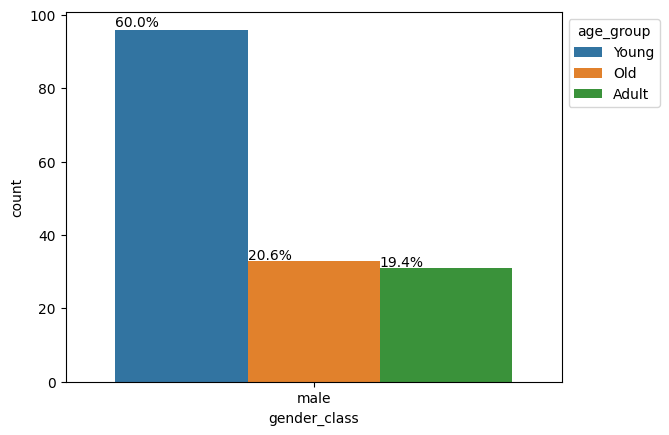

In [16]:
count_graph_with_hue(main_df, col1="gender_class"  , hue="age_group", top_count=1 )


### 🔎 Race information 

Race information is also obtained by both the [ner_jsl](https://nlp.johnsnowlabs.com/2023/07/31/ner_jsl_langtest_en.html) model and the [ner_sdoh](https://nlp.johnsnowlabs.com/2023/07/31/ner_sdoh_langtest_en.html) model using chunks from the exctract RACE_ETHNICITY entities.

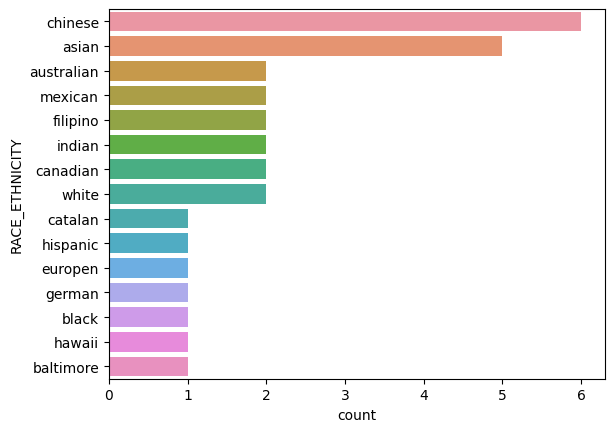

In [17]:
additional_dic = {"white american":"white",
                  "cat" : "catalan",
                  "caucasian":"europen",
                  "indian american":"indian"
}

black_list = ["saint","egg","fat"]

count_graph_with_hue(main_df, col1="RACE_ETHNICITY",exclude_terms = black_list,
                       additional_replacement_dict = additional_dic, top_count=15)

## 📊 SMOKER Analysis

In [18]:
# we can merge smoking and cigarette

additional_dic = {"cigarette":"smoking",
                  "drink":"alcohol",
                 }

### 🔎 When was smoking being talked about?

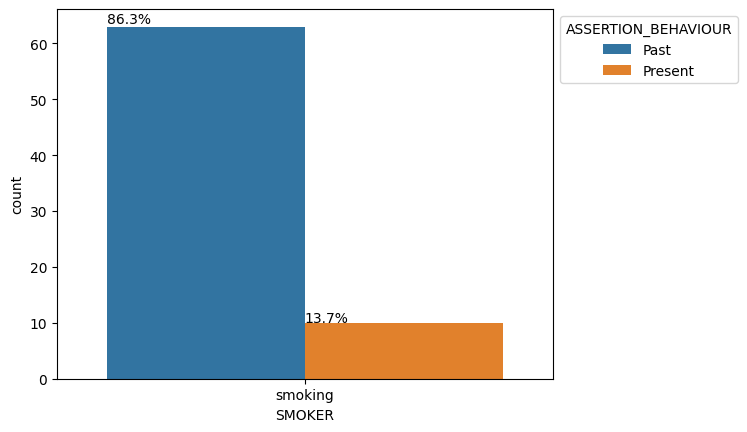

In [19]:
count_graph_with_hue(main_df, col1="SMOKER"  , hue="ASSERTION_BEHAVIOUR",
                       additional_replacement_dict = additional_dic, top_count=1 )

### 🔎Which ages talk about smoking?

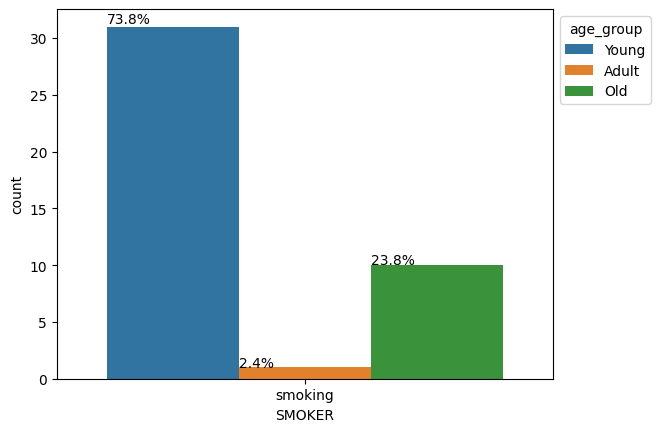

In [20]:
count_graph_with_hue(main_df, col1="SMOKER"  , hue="age_group",
                       additional_replacement_dict = additional_dic, top_count=1)

### 🔎 Which gender talks about smoking?
 
 or What is the tendency of talking about smoking among genders?
 
 or Is there a difference in how frequently men and women talk about smoking?

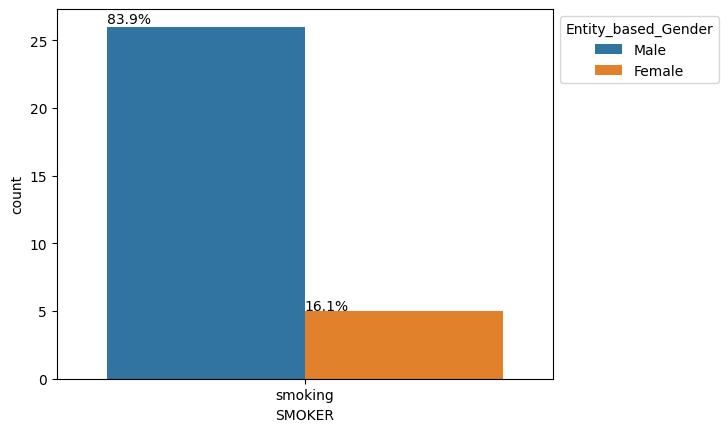

In [21]:
count_graph_with_hue(main_df, col1="SMOKER"  , hue="Entity_based_Gender",
                       additional_replacement_dict = additional_dic, top_count=1 )

### 🔎 What is the smoking related health problems?
or What smoking related health problems did they mention?
or What smoking related health problems were talked about?

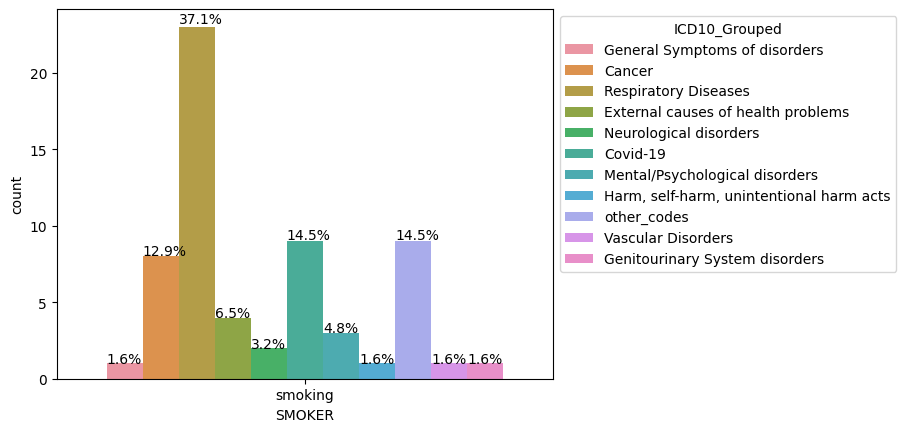

In [22]:
count_graph_with_hue(main_df, col1="SMOKER"  , hue="ICD10_Grouped",
                   additional_replacement_dict = additional_dic,   top_count=2 )

## 📊 ALCOHOL Analysis

In [23]:
additional_dic = {"alcoholism":"alcohol",
                  "drink":"alcohol",
                  "drinking addiction":"alcohol",
                  "wine":"alcohol",
                  
                 }

### 🔎 When was alcohol being talked about?

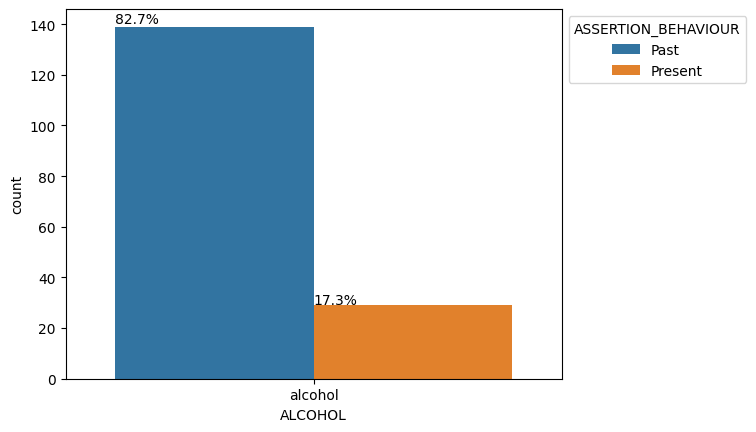

In [24]:
count_graph_with_hue(main_df, col1="ALCOHOL"  , hue="ASSERTION_BEHAVIOUR",
                      additional_replacement_dict =additional_dic, top_count=1 )

### 🔎Which ages talk about alcohol?

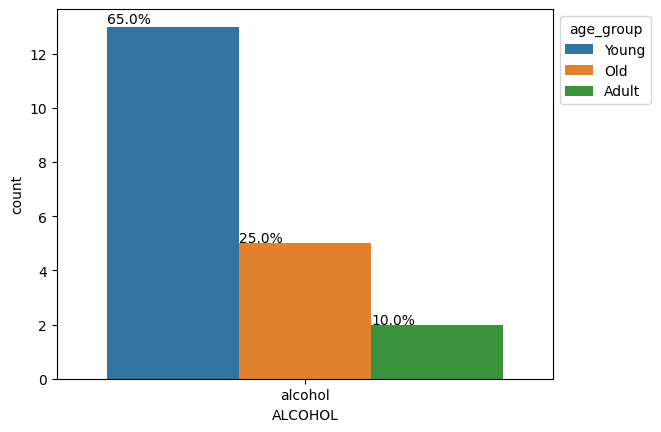

In [25]:
count_graph_with_hue(main_df, col1="ALCOHOL"  , hue="age_group",
                        additional_replacement_dict =additional_dic, top_count=1 )

### 🔎 Which gender talks about alcohol?

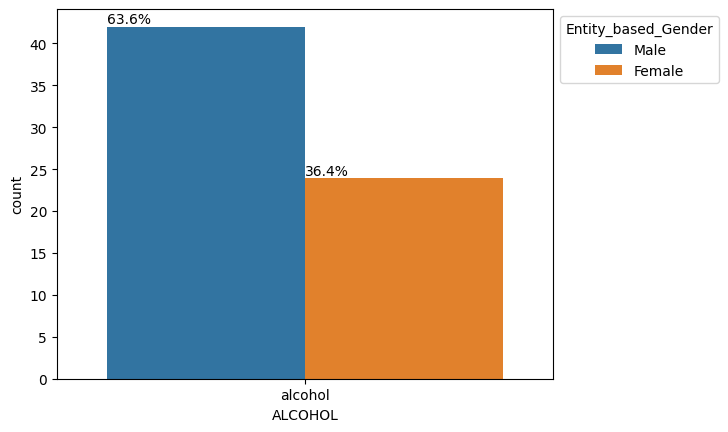

In [26]:
count_graph_with_hue(main_df, col1="ALCOHOL"  , hue="Entity_based_Gender",
                        additional_replacement_dict =additional_dic, top_count=1 )

### 🔎 What is the alcohol related health problems?

or What alcohol related health problems did they mention?

or What alcohol related health problems were talked about?

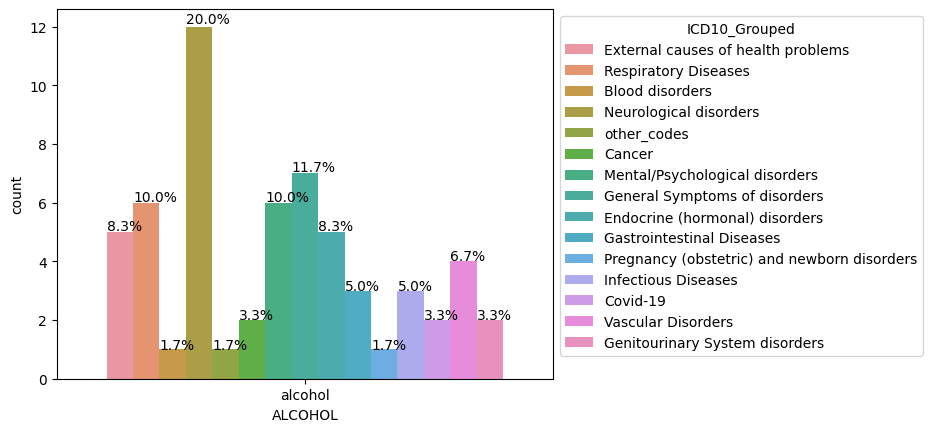

In [27]:
count_graph_with_hue(main_df, col1="ALCOHOL"  , hue="ICD10_Grouped",
                        additional_replacement_dict =additional_dic, top_count=1)

### 🔎 Alcohol and its Psychological Implications: Top Psychological Conditions Correlated with Alcohol Use

This match is rather good. depression and anxiety would also be expected.

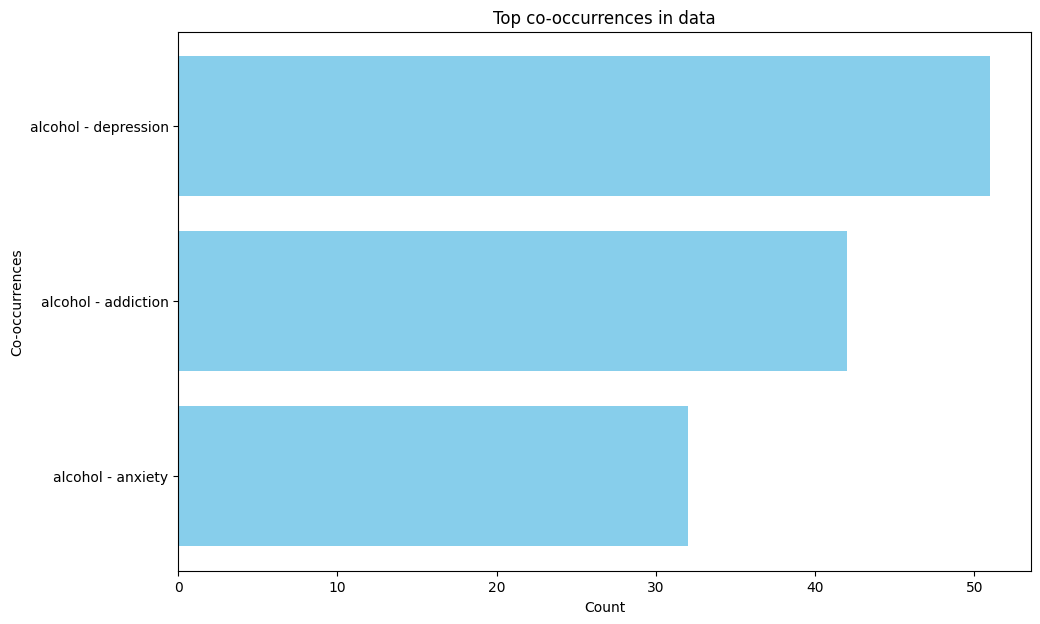

In [28]:
plot_bar_graph(main_df, "ALCOHOL", "PSYCHOLOGICAL_CONDITION", bar_count=3,
               replacement_dict = replacement_dict,additional_replacement_dict =additional_dic)

###  🔎 How prevalent is smoking among alcohol users?

This is a strong addiction couple, makes sense.

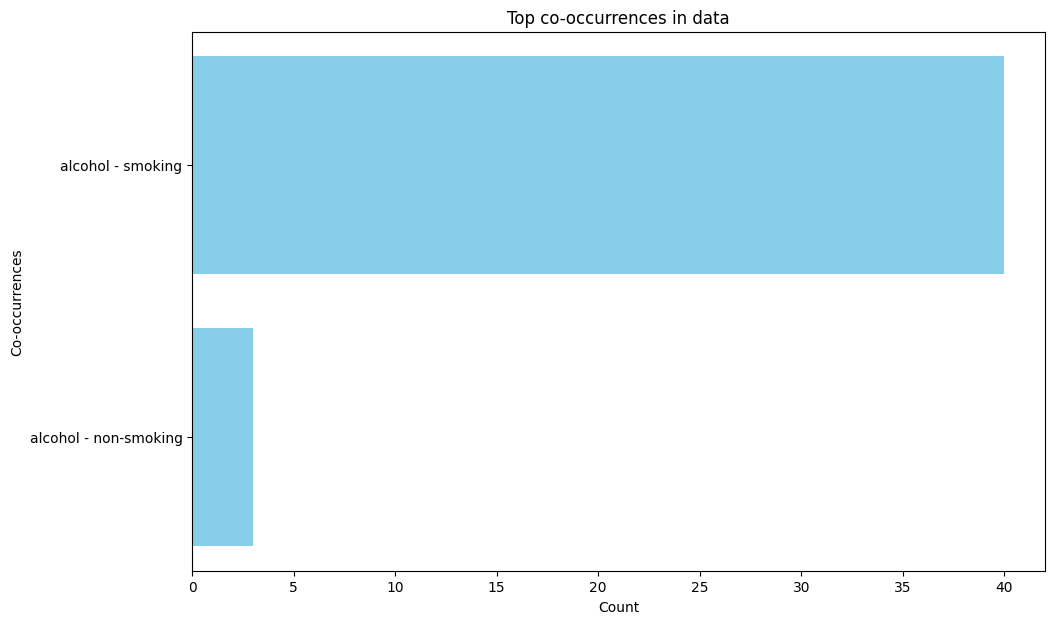

In [29]:
additional_dic = {"alcoholism":"alcohol",
                  "drink":"alcohol",
                  "drinking addiction":"alcohol",
                  "wine":"alcohol",
                  "Non addicted smoker":"non-smoking"
                  
                 }

plot_bar_graph(main_df, "ALCOHOL", "SMOKER", bar_count=2,
               additional_replacement_dict = additional_dic)

## 📊 SUBSTANCE Analysis

In [30]:
additional_dic = {"drug addiction":"drugs",
                 "drug":"drugs",
                  "addicted":"addiction",
                  "cocaine":"drugs",
                  "coffee":"caffeine",
                  "crack":"drugs"
                 }

black_list= ["addiction"]

### 🔎 When was substance being talked about?

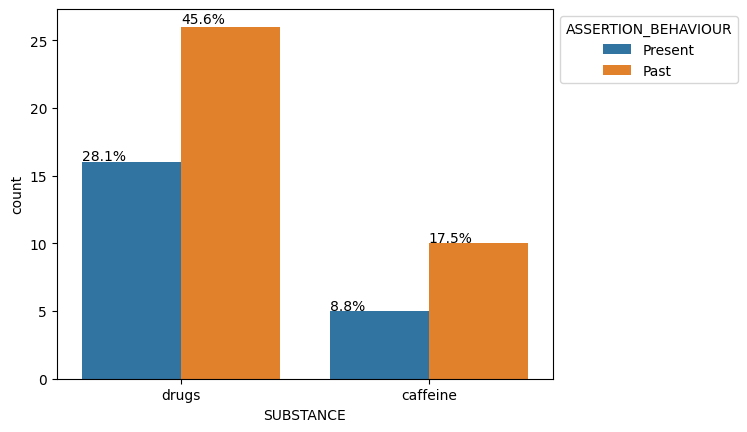

In [31]:

count_graph_with_hue(main_df, col1="SUBSTANCE"  , hue="ASSERTION_BEHAVIOUR", exclude_terms= black_list,
                       additional_replacement_dict =additional_dic, top_count=2 )

### 🔎Which gender tends to use which substances?

Nice match. Men are all addicted to something.

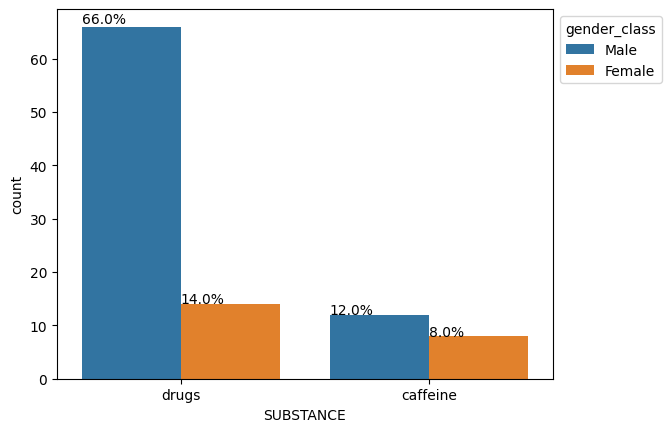

In [32]:
count_graph_with_hue(main_df, col1="SUBSTANCE"  , hue="gender_class",top_count=2,
                        additional_replacement_dict =additional_dic, exclude_terms= black_list,)

### 🔎Which ages talk about substance?

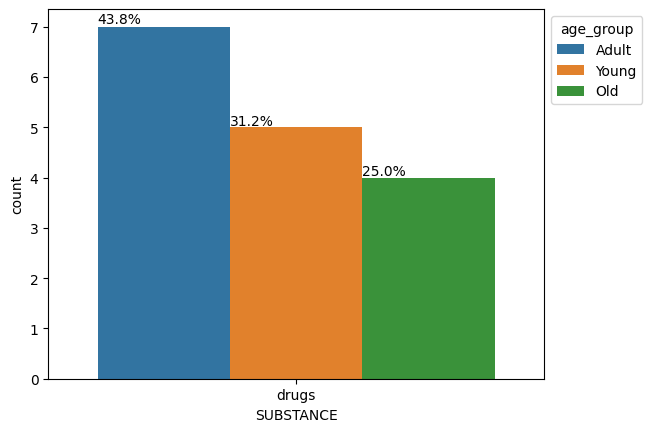

In [33]:
count_graph_with_hue(main_df, col1="SUBSTANCE"  , hue="age_group", top_count=1,
                    additional_replacement_dict=additional_dic, exclude_terms= black_list, )

### 🔎 Which gender talks about substance?

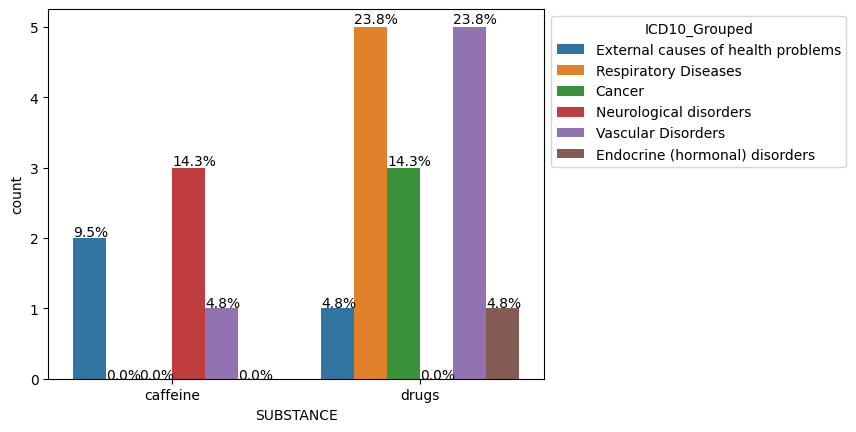

In [34]:
count_graph_with_hue(main_df, col1="SUBSTANCE"  , hue="ICD10_Grouped", top_count=3,
                       additional_replacement_dict =additional_dic, )

## 📊 DISEASE

In [35]:
additional_dic = {"anxious":"anxiety",
                  "stress":"anxiety",
                  "panic attacks":"panic attack",
                  "mom":"parents",
                  "dad":"parents",
                  "allergic":"allergy"}

black_list= ["Alzheimer's","potato starch"]

### What are the most common disorders being talked between genders?

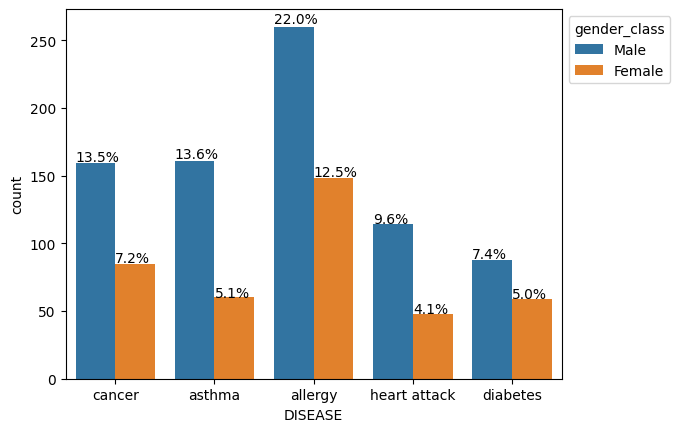

In [36]:
count_graph_with_hue(main_df, col1="DISEASE", hue="gender_class", top_count=5,
                     additional_replacement_dict=additional_dic )

### 🔎🔎 Which ages talk about diseases?

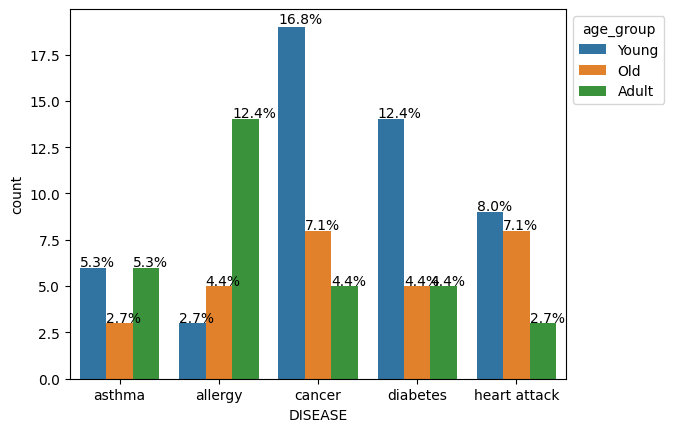

In [37]:
count_graph_with_hue(main_df, col1="DISEASE"  , hue="age_group", top_count=5,
                       additional_replacement_dict =additional_dic  )

### 🔎 Disease and Distress: Top Psychological Conditions Associated with Certain Diseases

Depression and anxiety are the most related issiues to mental health in modern world. It makes sense. PTSD is also rather common in generations.

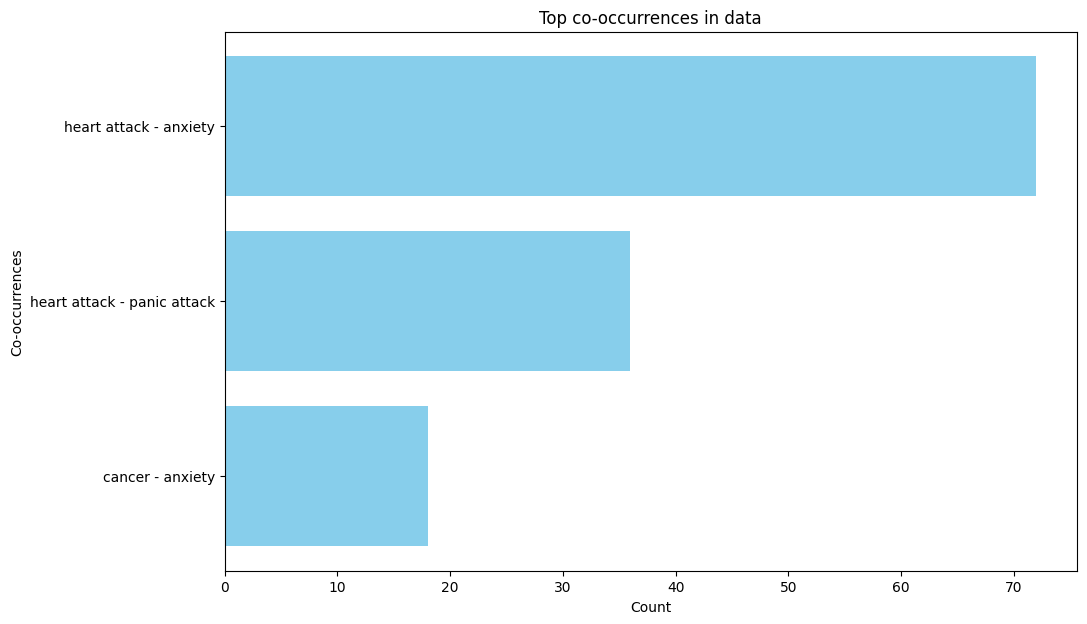

In [38]:
plot_bar_graph(main_df, "DISEASE", "PSYCHOLOGICAL_CONDITION", bar_count = 3,
               additional_replacement_dict = additional_dic, exclude_terms= black_list, )

###  🔎 Which diseases are most prevalent among parents?


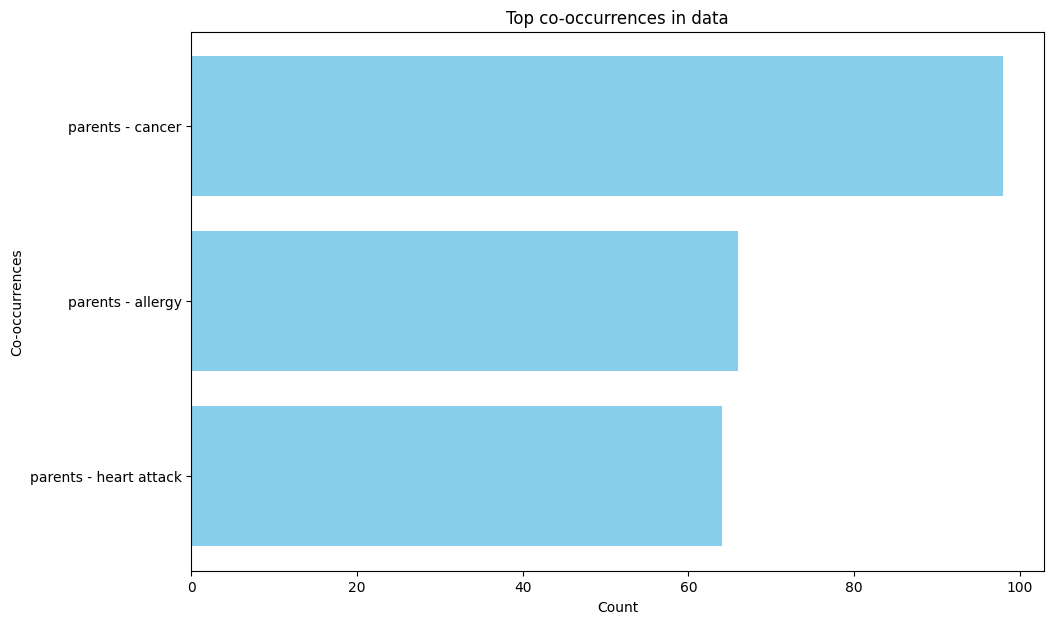

In [39]:
plot_bar_graph(main_df, "FAMILY_MEMBER", "DISEASE", replacement_dict = replacement_dict,additional_replacement_dict = additional_dic,bar_count = 3,)

## 📊 PSYCHOLOGICAL_CONDITION

### 🔎 Which psychological states are more frequently associated with different genders?
This is a very good match. Results make sense.

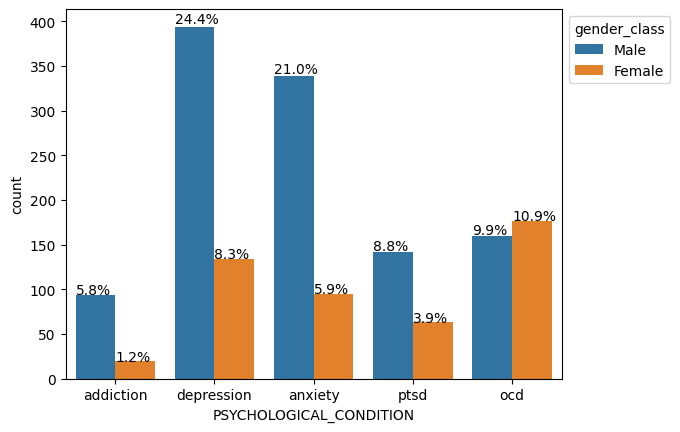

In [40]:
count_graph_with_hue(main_df, col1="PSYCHOLOGICAL_CONDITION", hue="gender_class",
                       additional_replacement_dict =additional_dic, top_count=5 )

### 🔎 Which psychological states are more frequently associated with ages?

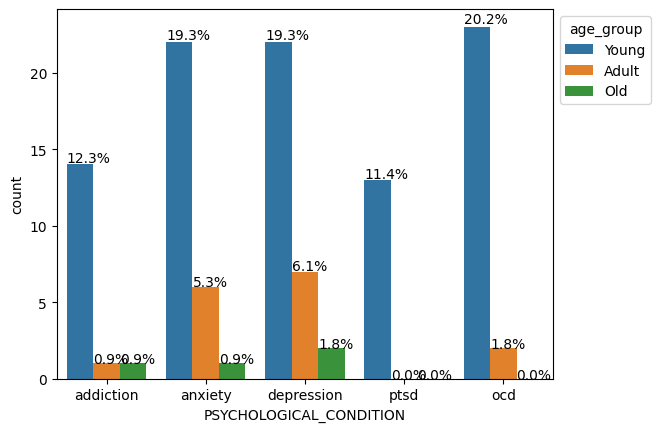

In [41]:
count_graph_with_hue(main_df, col1="PSYCHOLOGICAL_CONDITION"  , hue="age_group",
                       additional_replacement_dict =additional_dic, top_count=5 )

### 🔎 What are the most frequent physiological conditions in relation to drugs?

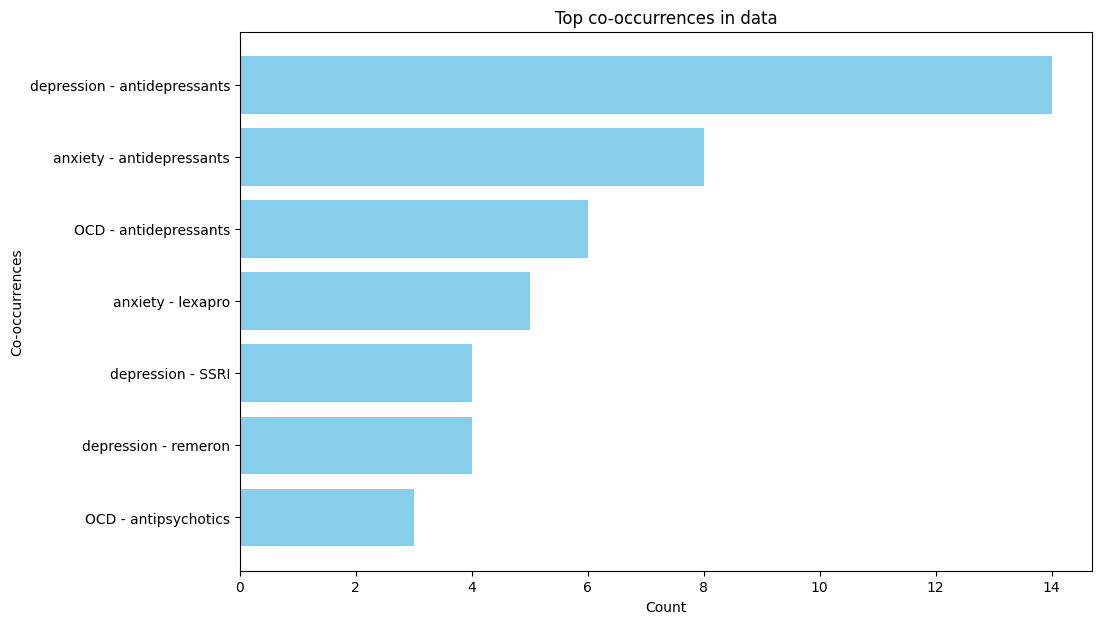

In [42]:
additional_dic = {"anti depressants":"antidepressants"}

black_list= ["I'm", "Prime"]

plot_bar_graph(main_df, "PSYCHOLOGICAL_CONDITION", "DRUG", exclude_terms = black_list,
               additional_replacement_dict = additional_dic, bar_count = 8)

### 🔎 What specific symptoms are related to certain physiological conditions?

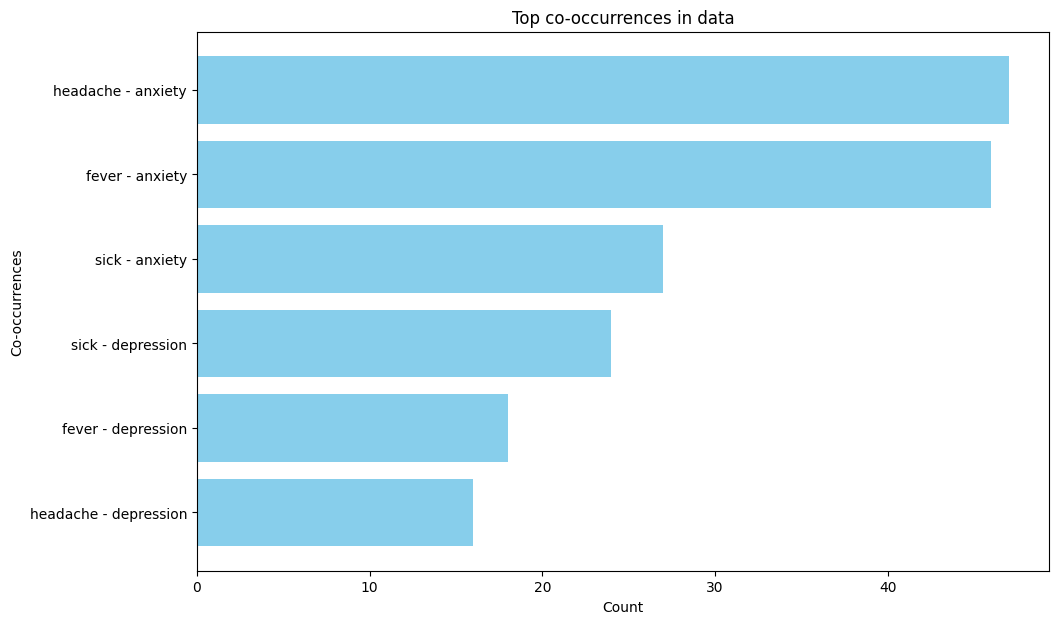

In [43]:
additional_dic = {}

black_list= []

plot_bar_graph(main_df,  "SYMPTOM","PSYCHOLOGICAL_CONDITION", exclude_terms = black_list,
               additional_replacement_dict = additional_dic, bar_count = 6)

## 📊  ALLERGEN

In [44]:
additional_dic = {"allergies":"allergy",
                  "allergic":"allergy",
                 "peanut intolerant":"allergy"}

black_list= ["EoE","beef allergy"]

### 🔎 What are the most prominent allergens?

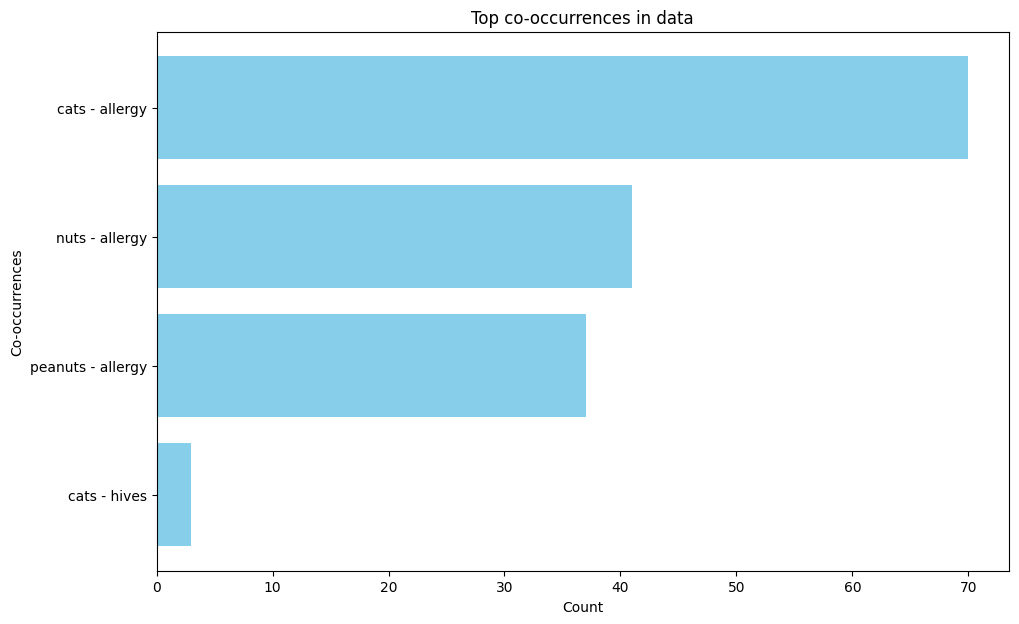

In [45]:
plot_bar_graph(main_df, "ALLERGEN", "DISEASE", exclude_terms = black_list,
               additional_replacement_dict = additional_dic, bar_count = 4)

### 🔎 Which drug consumption are related to the certain diseases?

In [46]:
additional_dic = {"type 1 diabetes":"diabetes",
                  "type one diabetes":"diabetes",
                  "Diabetes sucks!":"diabetes",
                  "disease sucks":"diabetes",
                  "insulin resistance":"pre-diabetes",

                 }

black_list= ["viibryd"]

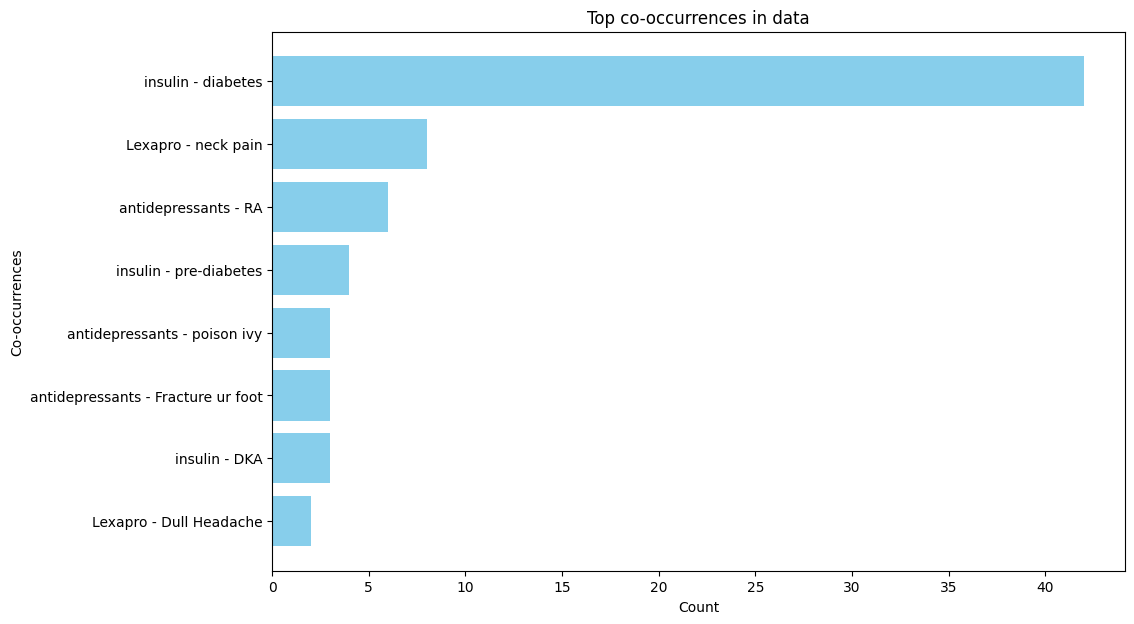

In [47]:
plot_bar_graph(main_df, "DRUG", "DISEASE", exclude_terms = black_list,
               additional_replacement_dict = additional_dic, bar_count = 10)

## 📊 EXERCISE

### 🔎 What is the exercise tendency among genders?

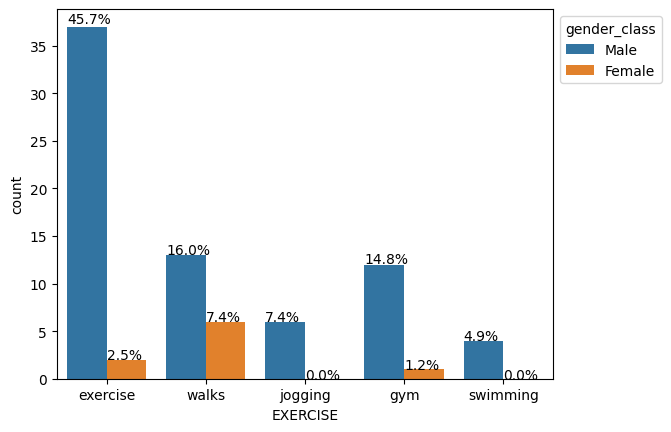

In [48]:
additional_dic = {"exercising":"exercise",
                  "exercised":"exercise",
                  "walking":"walks",                 }

count_graph_with_hue(main_df, col1="EXERCISE"  , hue="gender_class",
                       additional_replacement_dict =additional_dic, top_count=5 )